## Import libraries

In [148]:
# math
import math
import numpy as np
from numpy.random import multivariate_normal as mvn
import numpy.linalg as la
from scipy.stats import ortho_group, uniform, bernoulli
from scipy.linalg import sqrtm, norm, expm, logm, eigh, eigvalsh
from scipy.optimize import minimize
from scipy.special import softplus  # stable log(1+exp)

# plotting/visualization
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

# python utils
from functools import partial
from jax import hessian

## Utils

### basic matrix utils

In [149]:
def gen_matrix_with_eigs(eigs):
    """
    Generates a symmetric matrix with eigenvalues `eigs`.
    """
    dim = len(eigs)
    x = ortho_group.rvs(dim)
    return x.T @ np.diag(eigs) @ x

def gen_matrix_with_eigbounds(low, high, dim: int):
    """
    Generates a symmetric matrix with eigenvalues within [low, high].
    """
    eigs = low + (high - low) * uniform.rvs(size=dim)
    return gen_matrix_with_eigs(eigs)

def enforce_spd(S, eps=1e-15):
    """Project a symmetric matrix to SPD by eigenvalue flooring."""
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)                 # symmetric eigendecomp is most stable
    # scale-aware floor: keeps conditioning sane without over-regularizing
    # floor = max(eps, 1e-12 * max(1.0, np.max(np.abs(w))))
    w_clipped = np.clip(w, eps, None)
    return (V * w_clipped) @ V.T

def safe_inv_spd(S, eps=1e-15):
    """Inverse via eigen-decomposition with eigenvalue flooring (SPD only)."""
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)
    # floor = max(eps, 1e-12 * max(1.0, np.max(np.abs(w))))
    floor = eps
    w_clipped = np.clip(w, floor, None)
    inv_w = 1.0 / w_clipped
    return (V * inv_w) @ V.T

def mvn_safe(mu, Sigma, size=1, rng=None):
    """Multivariate normal with SPD projection and Cholesky."""
    if rng is None:
        rng = np.random.default_rng()
    Sigma = enforce_spd(Sigma)
    L = np.linalg.cholesky(Sigma)
    mu = np.asarray(mu)
    d = mu.shape[0]
    z = rng.normal(size=(size, d))
    return mu + z @ L.T

### BW geometry related utils

In [150]:
def grad_transport_map(Sigma_0, Sigma_1):
  """
  Return Gradient of Transport map between N(0, Sigma_0), N(0,Sigma_1) = sqrt(0)^-1 @ sqrt(sqrt(0) @ 1 @ sqrt(0)) @ sqrt(0)^-1 = 0^-1 @ sqrt(0 @ 1)
  https://math.stackexchange.com/questions/1117029/properties-of-the-matrix-square-root
  """
  # Sigma_0 = enforce_spd(Sigma_0)
  # Sigma_1 = enforce_spd(Sigma_1)
  end = sqrtm(Sigma_0 @ Sigma_1)
  return np.linalg.inv(Sigma_0) @ end

def gaussian_composition(mu_1, a, S, b, R):
  """
  Return the composition of the transport map at (a,S) in N(mu_1, Sigma_1) (a,S) circ (b,R)
  """
  vec = a + S.dot(b) - S.dot(mu_1)
  mat = S @ R
  return vec, mat

def gaussian_transport(Sigma_0, Sigma_1, a, S):
  """
  Transports the vector (a,S) in T_Sigma_1 BW to T_Sigma_0 BW
  """
  vec = a
  mat = S @ grad_transport_map(Sigma_0, Sigma_1)
  return vec, mat


def gaussian_interpolation(mean_0, Sigma_0, mean_1, Sigma_1, t):
  """
  Return interpolating Gaussian distribution
  """
  mean_t = (1 - t) * mean_0 + t * mean_1
  Sigma_t = ((1-t)**2) * Sigma_0 + t * (1-t) * (sqrtm(Sigma_0 @ Sigma_1) + sqrtm(Sigma_1 @ Sigma_0)) + (t ** 2) * Sigma_1
  return mean_t, Sigma_t

def bw_inner_product(a, S, b, R, Sigma):
  vec = np.dot(a,b)
  mat = np.linalg.trace(S @ Sigma @ R)
  return vec + mat

### Misc

In [151]:
def softmax(x):
    """
    Univariate softmax function.
    """
    return np.exp(x) / (1 + np.exp(x))

### Taget functional related utils

In [152]:
def V(mu_0, mu_1, Sigma_0, Sigma_1):
  """
  Return E(V(X)) if V = (X-mu_1)^T Sigma_1 (X-mu_1)/2
  https://statproofbook.github.io/P/mean-qf.html
  """
  Sigma_1_inv = safe_inv_spd(Sigma_1)
  first_term = (mu_0 - mu_1).T @ Sigma_1_inv @ (mu_0 - mu_1)
  second_term = np.trace(Sigma_1_inv @ Sigma_0)
  return first_term + second_term

def H(mu, Sigma):
    """
    Return E_q[log q(theta)] for q = N(mu, Sigma)
    (i.e., the negative differential entropy).
    """
    Sigma = 0.5 * (Sigma + Sigma.T)           # symmetrize
    d = Sigma.shape[0]
    sign, logdet = np.linalg.slogdet(Sigma)
    if sign <= 0:
      raise ValueError("Sigma must be SPD.")
    # E_q[log q] = -0.5 * [ d(1 + log(2π)) + log det Σ ]
    return -0.5 * (d * (1.0 + np.log(2.0 * np.pi)) + logdet)

def kl_divergence(mu_0, mu_1, Sigma_0, Sigma_1):
  """
  Return the KL divergence
  KL( N(mu_0, Sigma_0) || N(mu_1, Sigma_1) ).
  """
  d = mu_0.shape[0]

  det_0 = np.linalg.det(Sigma_0)
  det_1 = np.linalg.det(Sigma_1)
  Sigma_1_inv = np.linalg.inv(Sigma_1)
  div = np.log(det_1) - np.log(det_0)
  div -= d
  div += (Sigma_1_inv * Sigma_0).sum()
  div += (mu_1 - mu_0).T @ Sigma_1_inv @ (mu_1 - mu_0)
  div /= 2
  return div
  # return V(mu_0, mu_1, Sigma_0, Sigma_1) + H(mu_0, Sigma_0)

def wasserstein_dist(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the squared W2 distance between N(mu_0, Sigma_0), N(mu_1, Sigma_1).
    """
    half_0 = sqrtm(Sigma_0)
    half_1 = sqrtm(Sigma_1)
    return np.sum((mu_0 - mu_1) ** 2) + np.sum((half_0 - half_1) ** 2)

def laplace_approx(dim, log_potential, grad_V, hess_V):
  """
  Compute Laplace approximation to target distribution.
  """

  x0 = np.zeros(dim)

  # compute MAP
  result = minimize(log_potential, x0, jac = grad_V, hess = hess_V)
  mu = result.x

  # compute Hessian at map
  H = hess_V(mu)

  # compute inverse of Hessian to obtain Sigma
  Sigma = np.linalg.inv(H)

  return mu, Sigma

def empirical_kl(mu, Sigma, log_potential_pure, size = 1000):
  """
  Compute the empirical KL divergence
  to the unnormalized target as a distance objective.
  """
  # draw random samples from N(mu, Sigma) to approximate F(p_k).
  theta = mvn_safe(mu, Sigma, size = size).T

  # compute empirical expectation of V
  log_potentials = log_potential_pure(theta)
  assert log_potentials.shape == (size, )
  EE_V = log_potentials.mean()
  return EE_V + H(mu, Sigma)

def empirical_FI(mu, Sigma, grad_pure, size = 1000):
    """
    Compute the empirical log Fisher information as a distance objective.
    """
    Sigma_inv = safe_inv_spd(Sigma)

    # x: (d, m)
    x = mvn(mu, Sigma, size=size).T
    d, m = x.shape

    # grad_pure must support batched theta: (d, m) -> (m, d)
    grad_stack = grad_pure(x)
    if grad_stack.shape == (d, m):   # safety in case function returns (d,m)
        grad_stack = grad_stack.T
    # grad_stack: (m, d)

    expected_grad = grad_stack.mean(axis=0)           # (d,)

    # XC: centered samples, shape (m, d)
    XC = (x.T - mu)

    # integration-by-parts estimate of E[∇²V]
    expected_hess = 0.5 * (grad_stack.T @ XC) / m     # (d, d)
    # (optional: symmetrize before/after multiplying by Σ^{-1}; we keep after)
    expected_hess = expected_hess @ Sigma_inv
    expected_hess = 0.5 * (expected_hess + expected_hess.T)

    # BW gradient estimate: shape (d, m)
    bw_grad = (
        expected_grad[:, None]              # (d,1) -> broadcast over m
        + (XC @ expected_hess).T            # (d, m)
        - (XC @ Sigma_inv).T                # (d, m)
    )

    return np.log((bw_grad ** 2).sum(axis=0).mean())

### Wasserstein gradient descent module for KL minimization

In [153]:
# nabla 1 and nabla 2 gets the E(nabla V) and E(nabla^2 V)
def one_step_grad(mu_k, Sigma_k, nabla_1, nabla_2, stepsize, dim, prox = False):
  # mu update
  mu_k = mu_k - stepsize * nabla_1
  # Sigma update
  if not prox:
    # compute gradient in Sigma
    # Sigma_inv_k = safe_inv_spd(Sigma_k)
    Sigma_inv_k = np.linalg.inv(Sigma_k)
    M = np.eye(dim) - stepsize * (nabla_2 - Sigma_inv_k)
    Sigma_k = M @ Sigma_k @ M
  else:
    M_half = np.eye(dim) - stepsize * nabla_2
    Sigma_half = M_half @ Sigma_k @ M_half
    # do backward step for the entropy
    sqrt_matrix = sqrtm(
        Sigma_half @ (Sigma_half + 4 * stepsize * np.eye(dim))
    )
    sqrt_matrix = np.real(sqrt_matrix)
    Sigma_k = 0.5 * (Sigma_half + 2 * stepsize * np.eye(dim) + sqrt_matrix)
  return mu_k, Sigma_k

## Task 1: Adaptive GVI on Gaussian target (Appendix)

### Orcale for E(\nabla V) and E(\nabla^2 V)

In [7]:
def gradient_oracle_gaussian(mu, Sigma, mu_true, Sigma_true_inv):
  """
  Orcale to obtain \grad \calV.
  Note: NOT the oracle for \grad \calF (to incorporate Forward-Backward method).
  """  
  #if not stochastic:
  nabla_1 = Sigma_true_inv @ (mu - mu_true)
  nabla_2 = Sigma_true_inv
  # else:
  #   x = mvn_safe(mu, Sigma, size = size)
  #   xbar = np.mean(x, axis=0)
  #   nabla_1 = Sigma_true_inv @ (xbar - mu_true)
  #   nabla_2 = Sigma_true_inv
  return nabla_1, nabla_2

### Wasserstein GD with Gaussian target

In [136]:
def wasser_gds_gaussian(dim, mu_true, Sigma_true, num_iter, step_size = 1,
               adaptive = True, ours = True, A_order = 0,
               prox = False, init_mu = None, init_Sigma = None, delta =  1e-9):
  """
  Conduct GD for KL(\mu || \pi) = V(\mu) + H(\mu)
  """
  # create a list to save the result
  gd_kl_list = []
  gd_w2_list = []
  eigenvalue_list = []

  # initialize
  if init_mu is None:
    gd_mu_k = np.zeros(dim)
  else:
    gd_mu_k = init_mu
  if init_Sigma is None:
    gd_Sigma_k = np.eye(dim)
  else:
    gd_Sigma_k = init_Sigma

  # Get Sigma_inv
  Sigma_true_inv = np.linalg.inv(Sigma_true)

  # save the initial result: log error
  current_gd_kl = kl_divergence(gd_mu_k, mu_true, gd_Sigma_k, Sigma_true)
  gd_kl_list.append(current_gd_kl)
  # w2 distance
  current_gd_w2 = wasserstein_dist(gd_mu_k, mu_true, gd_Sigma_k, Sigma_true)
  gd_w2_list.append(current_gd_w2)
  # create a step-size list
  stepsize_list = []

  # For adaptive methods
  list_len = num_iter + 2
  A = [None] * (list_len)
  B = [None] * (list_len)
  for i in range(list_len):
    if A_order == 1:
      A[i] = (i+5)/2
      B[i] = (i+1)/2
    elif A_order == 0.5:
      a = 2
      A[i] = 2 * np.sqrt(i+a) + 2
      B[i] = 2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2)))
    elif A_order == 0:
      A[i] = 3
      B[i] = 5/4
    else:
      a = 2
      A[i] = 2 * np.power(i+a, A_order) + 2
      B[i] = A[i] - 2
  s0 = step_size
  s_t1 = s0
  L_e = L
  theta_t = 0
  s_prev = s_t1

  # run the gradient methods
  for curr_iter in range(2, num_iter + 1):
    # calculate gradient
    gd_nabla_1, gd_nabla_2 = gradient_oracle_gaussian(gd_mu_k, gd_Sigma_k, mu_true, Sigma_true_inv)
    # add smallest eigenvalue for logging
    eigenvalue_list.append(float(eigvalsh(gd_Sigma_k, subset_by_index=(0, 0), driver='evr', check_finite=False)[0]))
    # compute adaptive stepsize
    if adaptive:
      if ours:
        grad_vec_old = gd_nabla_1
        grad_mat_old = gd_nabla_2 - np.linalg.inv(gd_Sigma_k)
        lam_max = eigvalsh(grad_mat_old, subset_by_index=(dim-1, dim-1), driver='evr', check_finite=False)[0]
        lam_min = eigvalsh(grad_mat_old, subset_by_index=(0, 0),     driver='evr', check_finite=False)[0]
        t= curr_iter
        s_prev = s_t1
        if t == 0:
          s_t1 = min( 1/A[0] * s_prev, A[0] * B[0] / ( A[0]**2 + B[0] * (B[1] + 1) ) * 1/L_e)
        elif t >= 1:
          t = t+1
          r_s = (A[t-2]+1)/A[t-1]
          if L_e > 0:
            #if s_prev >= (1/L_e):
            r_l = A[t-1] * B[t-1] / ( A[t-1]**2 + B[t-1] * (B[t] + 1) )
            # else:
            #   r_l = A[t-1]/(B[t] + 1)
            s_t1 = min( r_s * s_prev, r_l * 1/L_e, (1-delta)/float(max(abs(lam_min), abs(lam_max))))
          else:
            s_t1 = min(r_s * s_prev, (1-delta)/float(max(abs(lam_min), abs(lam_max))))

        # adaptive GD update
        stepsize_list.append(s_t1)
        f_old = kl_divergence(gd_mu_k, mu_true, gd_Sigma_k, Sigma_true)
        gd_mu_next, gd_Sigma_next = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, s_t1, dim, prox = False)
        f_new = kl_divergence(gd_mu_next, mu_true, gd_Sigma_next, Sigma_true)
        # compute adaptive stepsize
        # Gradient oracle for V
        gd_nabla_1_next, gd_nabla_2_next = gradient_oracle_gaussian(
            gd_mu_next, gd_Sigma_next, mu_true, Sigma_true_inv
            )
        # gradient oracle for F
        grad_vec_new = gd_nabla_1_next
        grad_mat_new = gd_nabla_2_next - np.linalg.inv(gd_Sigma_next)
        # parallel transport
        g_new = gaussian_transport(
            gd_Sigma_k, gd_Sigma_next, grad_vec_new, grad_mat_new
        )
        g_old = (grad_vec_old, grad_mat_old)
        # compute L_k
        numerator = bw_inner_product(g_old[0] - g_new[0], g_old[1] - g_new[1], g_old[0] - g_new[0], g_old[1] - g_new[1], gd_Sigma_k)
        # maximum eigenvalue clipping of L_k
        if numerator == 0:
          L_e = 0
        else:
          denominator = -2*(f_new - f_old + s_t1 * bw_inner_product(g_old[0], g_old[1], g_new[0], g_new[1], gd_Sigma_k))
          L_e = np.exp(np.log(numerator) - np.log(denominator))
          if L_e < 0 or (math.isnan(L_e)):
            L_e = 0
      # Malitsky
      else:
        # stepsize update
        stepsize_list.append(s_t1)
        # gradient descent update
        gd_mu_next, gd_Sigma_next = one_step_grad(
            gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, s_t1, dim, prox=False
        )
        # gd_Sigma_next = enforce_spd(gd_Sigma_next)

        # Gradient at x_{k+1}
        gd_nabla_1_next, gd_nabla_2_next = gradient_oracle_gaussian(
            gd_mu_next, gd_Sigma_next, mu_true, Sigma_true_inv
        )
        grad_vec_next = gd_nabla_1_next
        grad_mat_next = gd_nabla_2_next - np.linalg.inv(gd_Sigma_next)

        # old gradient at x_k
        grad_vec_old = gd_nabla_1
        grad_mat_old = gd_nabla_2 - np.linalg.inv(gd_Sigma_k)
        g_new_on_old = gaussian_transport(
            gd_Sigma_k, gd_Sigma_next, grad_vec_next, grad_mat_next
        )
        new_vec_on_old, new_mat_on_old = g_new_on_old

        # Riemannian norms (not squared) with parallel transport
        norm_prev = math.sqrt(
            bw_inner_product(grad_vec_old, grad_mat_old,
                            grad_vec_old, grad_mat_old, gd_Sigma_k)
        )
        diff_vec = new_vec_on_old - grad_vec_old
        diff_mat = new_mat_on_old - grad_mat_old
        norm_diff = math.sqrt(
            bw_inner_product(diff_vec, diff_mat, diff_vec, diff_mat, gd_Sigma_k)
        )

        # L_e^{-1} = alpha_{k-1} * ||g_{k-1}|| / (sqrt(2) * ||g_k - P g_{k-1}||)
        if (norm_diff == 0.0) or math.isnan(norm_diff):
            s_next = math.sqrt(1.0 + theta_t) * s_prev
        else:
            L_e_inv = (s_prev * norm_prev) / (math.sqrt(2.0) * norm_diff)
            s_next = min(math.sqrt(1.0 + theta_t) * s_prev, L_e_inv)

        theta_t = 0.0 if s_prev == 0.0 else (s_next / s_prev)

        s_prev = s_next
        s_t1   = s_next

      # update
      gd_mu_k, gd_Sigma_k = gd_mu_next, gd_Sigma_next
    # Conduct Forward-Backward BWVI
    else:
      stepsize_list.append(step_size)
      if prox:
        # Forward-backward update
        gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, step_size, dim, prox = True)
      else:
        # Wasserstein GD
        gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, step_size, dim, prox = False)
      # gd_Sigma_k = enforce_spd(gd_Sigma_k)

    # save the result
    current_gd_kl = kl_divergence(gd_mu_k, mu_true, gd_Sigma_k, Sigma_true)
    gd_kl_list.append(current_gd_kl)
    # w2 distance
    current_gd_w2 = wasserstein_dist(gd_mu_k, mu_true, gd_Sigma_k, Sigma_true)
    gd_w2_list.append(current_gd_w2)

  # save the last result
  gd_mu_last = gd_mu_k
  gd_Sigma_last = gd_Sigma_k

  # return the result
  return gd_kl_list, gd_w2_list, gd_mu_last, gd_Sigma_last, stepsize_list, eigenvalue_list

### Simulations

Generate synthetic data

In [137]:
np.random.seed(123)
alpha = 1e-7
L = 1
eps = 1e-1
dim = 20
mu_true = uniform.rvs(size = (dim, ))
Sigma_true = gen_matrix_with_eigs(
  np.geomspace(1/L, 1/alpha, dim)
)

Run experiments

In [138]:
num_subiter = 1000 #alpha = 1e-13->35, 1e-07 = 20, 1e-03 = 9, 1e-01 = 4
A_order_experi = 0.1
# run experiment
gd_kl_list, gd_w2_list, gd_mu_last_j, gd_Sigma_last_j, stepsize_gd, eigenvalue_gd  = wasser_gds_gaussian(
    dim, mu_true=mu_true, Sigma_true = Sigma_true,
    num_iter= num_subiter, step_size=1/L, adaptive = False, prox=True
    )
print("GD Done")
adap_gd_kl_list_a0, adap_gd_w2_list_a0, adap_gd_mu_last_j_a0, adap_gd_Sigma_last_j_a0, stepsize_a0, eigenvalue_a0 = wasser_gds_gaussian(
    dim, mu_true=mu_true, Sigma_true = Sigma_true,
    num_iter= num_subiter, step_size=1/L, adaptive = True, ours=True, A_order = 0
    )
print("AdaGDO(1) Done")
adap_gd_kl_list_a05, adap_gd_w2_list_a05, adap_gd_mu_last_j_a05, adap_gd_Sigma_last_j_a05, stepsize_a05, eigenvalue_a05 = wasser_gds_gaussian(
    dim, mu_true=mu_true, Sigma_true = Sigma_true,
    num_iter= num_subiter, step_size=1/L, adaptive = True, ours=True, A_order = 0.5
    )
print("AdaGDO(1/2) Done")
adap_gd_kl_list_a1, adap_gd_w2_list_a1, adap_gd_mu_last_j_a1, adap_gd_Sigma_last_j_a1, stepsize_a1, eigenvalue_a1 = wasser_gds_gaussian(
    dim, mu_true=mu_true, Sigma_true = Sigma_true,
    num_iter= num_subiter, step_size=1/L, adaptive = True, ours=True, A_order = 1
    )
print("AdaGDO(n) Done")
adap_gd_kl_list_a01, adap_gd_w2_list_a01, adap_gd_mu_last_j_a01, adap_gd_Sigma_last_j_a01, stepsize_a01, eigenvalue_a01 = wasser_gds_gaussian(
    dim, mu_true=mu_true, Sigma_true = Sigma_true,
    num_iter= num_subiter, step_size=1/L, adaptive = True, ours=True, A_order = A_order_experi
    )
print(f"AdaGDO({A_order_experi})) Done")
# adap_gd_kl_list_mal, adap_gd_w2_list_mal, adap_gd_mu_last_j_mal, adap_gd_Sigma_last_j_mal, stepsize_mal, eigenvalue_mal = wasser_gds_gaussian(
#     dim, mu_true=mu_true, Sigma_true = Sigma_true,
#     num_iter= num_subiter, step_size=1/L, adaptive = True, ours=False, A_order = A_order_experi
#     )
# print("MalGD Done")

GD Done
AdaGDO(1) Done
AdaGDO(1/2) Done
AdaGDO(n) Done
AdaGDO(0.1)) Done


### Plotting the results

eigenvalues

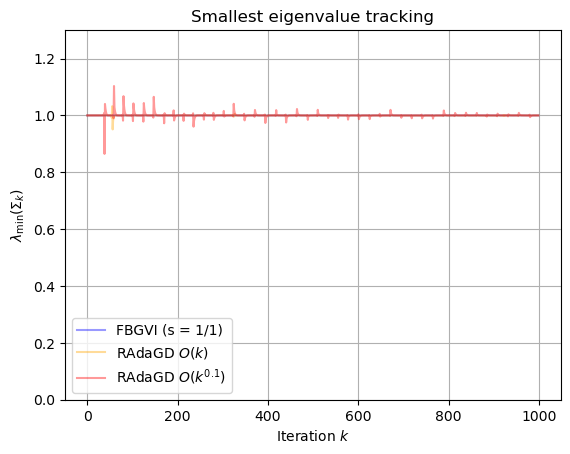

In [106]:
iterations = list(range((num_subiter-1))) 
# Create the x-axis (iteration numbers) 
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"] 
labels = [f"FBGVI (s = 1/{L})", "Riem adaptive GD (O(1))", "Riem adaptive GD (O(n^{0.5}))", r"RAdaGD $O(k)$", fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]"] 
# Labels for the legend 
min_val = min(np.min(eigenvalue_gd), np.min(eigenvalue_a1), np.min(eigenvalue_a01)) 
plt.plot(iterations, eigenvalue_gd, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4) 
#plt.plot(iterations, eigenvalue_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4) 
# #plt.plot(iterations, eigenvalue_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4) 
plt.plot(iterations, eigenvalue_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4) 
plt.plot(iterations, eigenvalue_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4) 
# plt.plot(iterations, eigenvalue_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.5) 

# # Add labels and title 
plt.xlabel(r"Iteration $k$") 
plt.ylabel(r"$\lambda_{{\min}}(\Sigma_k)$") 
plt.title("Smallest eigenvalue tracking" ) 

# plt.yscale('log', base = 10) 
# # plt.xscale('log',base=10) 
# plt.ylim(bottom = 0.0, top = 1.3) 
# # Add a legend 
plt.legend() 
# # Show the plot 
plt.grid(True) 
plt.show()

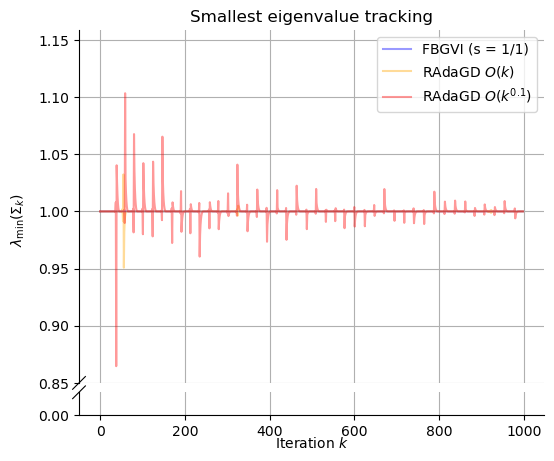

In [147]:
iterations = list(range(num_subiter-1))
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$", "[AM25]"]

min_val = min(np.min(eigenvalue_gd), np.min(eigenvalue_a1), np.min(eigenvalue_a01))
max_val = max(np.max(eigenvalue_gd), np.max(eigenvalue_a1), np.max(eigenvalue_a01))

fig = plt.figure(figsize=(6,5))

# generate brokenaxes
bax = brokenaxes(ylims=((0, 0.02), (0.85, 1.05*max_val)), hspace=.05, fig=fig)

# plot data
bax.plot(iterations, eigenvalue_gd, color=colors[0], label=labels[0], linestyle='-', alpha=0.4)
bax.plot(iterations, eigenvalue_a1, color=colors[3], label=labels[3], linestyle='-', alpha=0.4)
bax.plot(iterations, eigenvalue_a01, color=colors[4], label=labels[4], linestyle='-', alpha=0.4)

# labels
bax.set_xlabel(r"Iteration $k$")
# bax.set_ylabel(r"$\lambda_{\min}(\Sigma_k)$")
bax.set_title("Smallest eigenvalue tracking")
bax.legend()
bax.grid(True)
# y label to avoid collapsing
fig.text(0.01, 0.5, r"$\lambda_{\min}(\Sigma_k)$",
         va="center", rotation="vertical")
plt.show()


Stepsizes

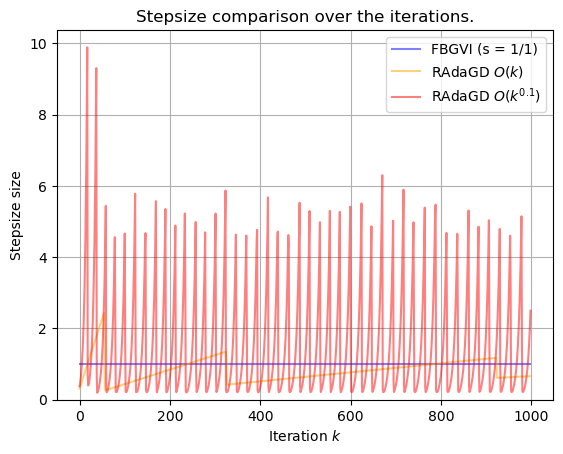

In [71]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]"] # Labels for the legend

plt.plot(iterations, stepsize_gd, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.5)
#plt.plot(iterations, stepsize_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, stepsize_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.5)
plt.plot(iterations, stepsize_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.5)
#plt.plot(iterations, stepsize_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
plt.ylim(bottom = 0.0)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

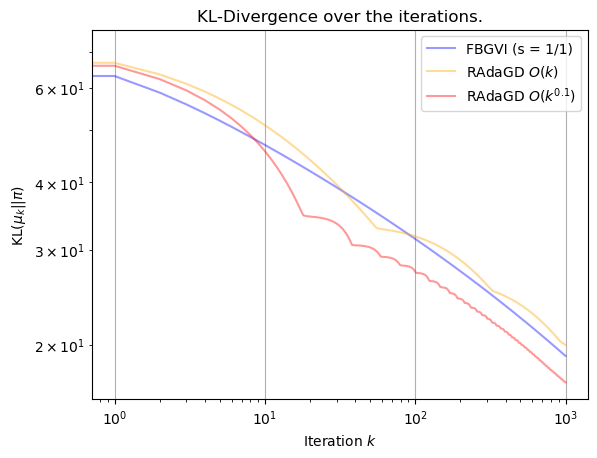

In [69]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]"] # Labels for the legend

plt.plot(iterations, gd_kl_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_kl_list_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_kl_list_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_kl_list_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"KL($\mu_k || \pi$)")
plt.title("KL-Divergence over the iterations." )
plt.xscale('log',base=10)
plt.yscale('log',base=10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Wasserstein distance

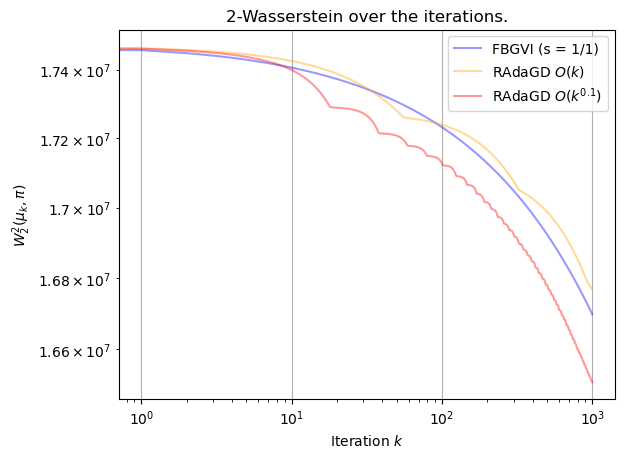

In [70]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]"] # Labels for the legend

plt.plot(iterations, gd_w2_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_w2_list_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_w2_list_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_w2_list_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_w2_list_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_w2_list_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"$W_2^2(\mu_k, \pi)$")
plt.title("2-Wasserstein over the iterations.")
plt.xscale('log',base=10)
plt.yscale('log',base=10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Task 2: Poisson Regression

### Target functional utils

In [154]:
def _theta_as_batch(theta, d):
    """Return (TH, was_single) where TH has shape (m, d)."""
    th = np.asarray(theta)
    if th.ndim == 1:
        if th.shape[0] != d:
            raise ValueError(f"theta has shape {th.shape}, expected (d,) with d={d}")
        return th[None, :], True               # (1, d)
    if th.ndim == 2:
        if th.shape == (1, d):  return th, True
        if th.shape == (d, 1):  return th.T, True
        if th.shape[1] == d:    return th, False   # (m, d)
        if th.shape[0] == d:    return th.T, False # (d, m) -> (m, d)
    raise ValueError(f"Unsupported theta shape {th.shape}; expected (d,), (m,d), or (d,m)")

# ---------------- Poisson negative log-likelihood pieces ----------------
def log_potential_poisson(theta, Y, X):
    """
    If theta is (d,), returns a scalar.
    If theta is batched ((m,d) or (d,m)), returns (m,) values.
    """
    n, d = X.shape
    TH, was_single = _theta_as_batch(theta, d)          # (m, d)
    Z = X @ TH.T                                        # (n, m)
    # Z = np.clip(Z, -50.0, 50.0)
    Lam = np.exp(Z)                                     # (n, m)
    Y = np.asarray(Y).reshape(n)
    vals = Lam.sum(axis=0) - (Y[:, None] * Z).sum(axis=0)   # (m,)
    return vals[0] if was_single else vals

def grad_V_poisson(theta, Y, X):
    """
    ∇V(θ) = X^T (exp(Xθ) - Y)
    If theta is (d,), returns (d,).
    If batched, returns (m, d).
    """
    n, d = X.shape
    TH, was_single = _theta_as_batch(theta, d)          # (m, d)
    Z = X @ TH.T                                        # (n, m)
    # Z = np.clip(Z, -50.0, 50.0)
    Lam = np.exp(Z)                                     # (n, m)
    Y = np.asarray(Y).reshape(n)
    G = (Lam - Y[:, None]).T @ X                        # (m, d)
    return G[0] if was_single else G

def hess_V_poisson(theta, Y, X):
    """
    ∇²V(θ) = X^T diag(exp(Xθ)) X
    If theta is (d,), returns (d, d).
    If batched, returns (m, d, d).
    """
    n, d = X.shape
    TH, was_single = _theta_as_batch(theta, d)          # (m, d)
    Z = X @ TH.T                                        # (n, m)
    # Z = np.clip(Z, -50.0, 50.0)
    Lam = np.exp(Z)                                     # (n, m)
    # H[m, :, :] = sum_i lam[i, m] * x_i x_i^T
    H = np.einsum('ni,nj,nm->mij', X, X, Lam)           # (m, d, d)
    return H[0] if was_single else H

def make_poisson_gaussian_moments(X, Y):
    X = np.asarray(X)
    y = np.asarray(Y)

    def moments(mu, Sigma, clip=None):
        # s2 = diag(X Σ X^T) computed vectorially
        XS = X @ Sigma                       # (n,d)
        s2 = np.einsum('nd,nd->n', XS, X)    # (n,)
        s = X @ mu + 0.5 * s2                 # (n,)
        if clip is not None:                 # optional numerical guard
            s = np.clip(s, -clip, clip)
        lam_bar = np.exp(s)                  # (n,)

        EV     = lam_bar.sum() - Y @ (X @ mu)                 # scalar
        Egrad  = X.T @ (lam_bar - Y)                         # (d,)
        EHess  = X.T @ (lam_bar[:, None] * X)                # (d,d)
        return EV, Egrad, EHess

    return moments

### Wasserstein GD for glm regression Module

In [155]:
def wasser_gds_glm(dim, glm_gaussian_moment_ftn, num_iter,
                       step_size = 1, adaptive = True, ours = True, A_order = 0,
                       prox = False, init_mu = None, init_Sigma = None, delta =  1e-7):
  """
  Conduct GD for KL(\mu || \pi) = V(\mu) + H(\mu)
  """
  # create a list to save the result
  gd_kl_list = []
  gd_FI_list = []
  # create a step-size list
  stepsize_list = []
  # eigenvalue list
  eigenvalue_list = []

  # initialize
  if init_mu is None:
    gd_mu_k = np.zeros(dim)
  else:
    gd_mu_k = init_mu
  if init_Sigma is None:
    gd_Sigma_k = np.eye(dim)
  else:
    gd_Sigma_k = init_Sigma

  # save the initial result: log error
  EV, _, _ = glm_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
  current_gd_kl = EV + H(gd_mu_k, gd_Sigma_k)
  gd_kl_list.append(current_gd_kl)
  # FI
  # current_gd_log_FI = empirical_FI(gd_mu_k, gd_Sigma_k, grad_pure, size = num_minibatch)
  # gd_FI_list.append(current_gd_log_FI)

  # For adaptive methods
  list_len = num_iter + 2
  A = [None] * (list_len)
  B = [None] * (list_len)
  for i in range(list_len):
    if A_order == 1:
      A[i] = (i+5)/2
      B[i] = (i+1)/2
    elif A_order == 0.5:
      a = 2
      A[i] = 2 * np.sqrt(i+a) + 2
      B[i] = 2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2)))
    elif A_order == 0:
      A[i] = 3
      B[i] = 5/4
    else:
      a = 2
      A[i] = 2 * np.power(i+a, A_order) + 2
      B[i] = A[i] - 2
  s0 = step_size
  s_t1 = s0
  L_e = L
  theta_t = 0
  s_prev = s_t1

  # run the gradient methods
  for curr_iter in range(2, num_iter + 1):
    # calculate gradient
    EV, gd_nabla_1, gd_nabla_2 = glm_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
    # add smallest eigenvalue for logging
    eigenvalue_list.append((eigvalsh(gd_Sigma_k, subset_by_index=(0, 0), driver='evr', check_finite=False)[0]))
    # compute adaptive stepsize
    if adaptive:
      if ours:
        grad_vec_old = gd_nabla_1
        grad_mat_old = gd_nabla_2 - np.linalg.inv(gd_Sigma_k)
        lam_max = eigvalsh(grad_mat_old, subset_by_index=(dim-1, dim-1), driver='evr', check_finite=False)[0]
        lam_min = eigvalsh(grad_mat_old, subset_by_index=(0, 0),     driver='evr', check_finite=False)[0]
        t= curr_iter
        s_prev = s_t1
        if t == 0:
          s_t1 = min( 1/A[0] * s_prev, A[0] * B[0] / ( A[0]**2 + B[0] * (B[1] + 1) ) * 1/L_e)
        elif t >= 1:
          t = t+1
          r_s = (A[t-2]+1)/A[t-1]
          if L_e > 0:
            #if s_prev >= (1/L_e):
            r_l = A[t-1] * B[t-1] / ( A[t-1]**2 + B[t-1] * (B[t] + 1) )
            # else:
            #   r_l = A[t-1]/(B[t] + 1)
            s_t1 = min( r_s * s_prev, r_l * 1/L_e, (1-delta)/(max(abs(lam_min), abs(lam_max))))
          else:
            s_t1 = min(r_s * s_prev, (1-delta)/(max(abs(lam_min), abs(lam_max))))

        # adaptive GD update
        stepsize_list.append(s_t1)
        f_old = EV + H(gd_mu_k, gd_Sigma_k)
        gd_mu_next, gd_Sigma_next = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, s_t1, dim, prox = False)
        # gd_Sigma_next = enforce_spd(gd_Sigma_next)
        EV_next, gd_nabla_1_next, gd_nabla_2_next = glm_gaussian_moment_ftn(gd_mu_next, gd_Sigma_next)
        f_new = EV_next + H(gd_mu_next, gd_Sigma_next)

        # compute adaptive stepsize
        grad_vec_new = gd_nabla_1_next
        grad_mat_new = gd_nabla_2_next - np.linalg.inv(gd_Sigma_next)
        g_new = gaussian_transport(
            gd_Sigma_k, gd_Sigma_next, grad_vec_new, grad_mat_new
        )
        g_old = (grad_vec_old, grad_mat_old)
        numerator = bw_inner_product(g_old[0] - g_new[0], g_old[1] - g_new[1], g_old[0] - g_new[0], g_old[1] - g_new[1], gd_Sigma_k)
        if numerator == 0:
          L_e = 0
        else:
          denominator = -2*(f_new - f_old + s_t1 * bw_inner_product(g_old[0], g_old[1], g_new[0], g_new[1], gd_Sigma_k))
          L_e = np.exp(np.log(numerator) - np.log(denominator))
          if L_e < 0 or (math.isnan(L_e)):
            L_e = 0
      # Malitsky
      else:
        stepsize_list.append(s_t1)
        # gradient step
        gd_mu_next, gd_Sigma_next = one_step_grad(
            gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, s_t1, dim, prox=False
        )
        # gd_Sigma_next = enforce_spd(gd_Sigma_next)

        _, gd_nabla_1_next, gd_nabla_2_next = glm_gaussian_moment_ftn(
            gd_mu_next, gd_Sigma_next
        )
        grad_vec_next = gd_nabla_1_next
        grad_mat_next = gd_nabla_2_next - np.linalg.inv(gd_Sigma_next)

        # old gradient at x_k (split like you already do)
        grad_vec_old = gd_nabla_1
        grad_mat_old = gd_nabla_2 - np.linalg.inv(gd_Sigma_k)

        # transport old → new, and measure differences at the NEW base point
        g_old_on_new = gaussian_transport(
            gd_Sigma_next, gd_Sigma_k, grad_vec_old, grad_mat_old
        )
        prev_vec_on_new, prev_mat_on_new = g_old_on_new

        # Riemannian norms (not squared) with correct base points
        norm_prev_sq = bw_inner_product(
            grad_vec_old, grad_mat_old, grad_vec_old, grad_mat_old, gd_Sigma_k
        )
        if norm_prev_sq >= 0:
          norm_prev = math.sqrt(norm_prev_sq)
        else:
          norm_prev = 0
        diff_vec = grad_vec_next - prev_vec_on_new
        diff_mat = grad_mat_next - prev_mat_on_new
        norm_diff_sq = bw_inner_product(diff_vec, diff_mat, diff_vec, diff_mat, gd_Sigma_next)
        if norm_diff_sq >= 0:
          norm_diff = math.sqrt(norm_diff_sq)
        else:
          norm_diff = 0

        if (norm_diff == 0.0) or math.isnan(norm_diff):
            s_next = math.sqrt(1.0 + theta_t) * s_prev

        else:
            L_e_inv = (s_prev * norm_prev) / (math.sqrt(2.0) * norm_diff)
            s_next = min(math.sqrt(1.0 + theta_t) * s_prev, L_e_inv)

        theta_t = 0.0 if s_prev == 0.0 else (s_next / s_prev)

        s_prev = s_next
        s_t1   = s_next

      gd_mu_k, gd_Sigma_k = gd_mu_next, gd_Sigma_next
    # Conduct Forward-Backward BWVI
    else:
      if prox:
        # Forward-backward update
        gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, step_size, dim, prox = True)
      else:
        # Wasserstein GD
        gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, step_size, dim, prox = False)
      # gd_Sigma_k = enforce_spd(gd_Sigma_k)
      stepsize_list.append(step_size)

    # save the initial result: log error
    EV, _, _ = glm_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
    current_gd_kl = EV + H(gd_mu_k, gd_Sigma_k)
    gd_kl_list.append(current_gd_kl)

  # save the last result
  gd_mu_last = gd_mu_k
  gd_Sigma_last = gd_Sigma_k

  # return the result
  return gd_kl_list, gd_FI_list, gd_mu_last, gd_Sigma_last, stepsize_list, eigenvalue_list

### Simulations

Synthetic data generations

In [156]:
np.random.seed(100)

num_sample, dim = 50, 25
X = mvn(np.zeros(dim), np.eye(dim), size=(num_sample))    # (n, d)

# --- design X: anisotropic + outliers --------------------------------------
# --- make X anisotropic and add leverage outliers -------------------------

# # (A) Column anisotropy: scale columns by a geometric range (raises κ(X^TX))
# scales = np.geomspace(1.0, 100.0, dim)                    # cond ~ 100
# X = X * scales                                            # broadcast over columns

# # (B) A few extreme rows along ±v (create huge exp(x_i^T θ) contrasts)
# k = max(1, int(0.1 * num_sample))                        # ~10% rows
# v = np.random.randn(dim)
# v /= (np.linalg.norm(v) + 1e-12)
# X[:k]      = 200 * v                                     # very large positive dot
# X[k:2*k]   = 200 * v                                    # very large negative dot

# optional global scaling (keeps conditioning manageable)
maxeig = np.linalg.eigvalsh(X.T @ X).max()
X = X / np.sqrt(maxeig)

# --- true parameter and Poisson outcomes -----------------------------------
true_theta = mvn(np.zeros(dim), np.eye(dim))                 # (d,)
z_true = X @ true_theta
# z_true = np.clip(z_true, -8.0, 8.0)                          # keep rates sane
lam_true = np.exp(z_true)                                    # (n,)
Y = np.random.poisson(lam_true)                              # (n,)

poisson_gaussian_moment_ftn = make_poisson_gaussian_moments(X, Y)

Experiments

In [157]:
# Guess L
L = 2
small_L = L/2
large_L = 2 * L

# Experiment setup
num_subiter = 1000
A_order_experi = 0.1

# run experiment
fb_kl_list, fb_FI_list, fb_mu_last_j, fb_Sigma_last_j, stepsize_fb, eigenvalue_fb  = wasser_gds_glm(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = False, prox = True
    )
print("FB Done")
# adap_gd_kl_list_a0, adap_gd_FI_list_a0, adap_gd_mu_last_j_a0, adap_gd_Sigma_last_j_a0, stepsize_a0, eigenvalue_a0 = wasser_gds_poisson(
#     dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = 0
#   )
# print("AdaGDO(1) Done")
# adap_gd_kl_list_a05, adap_gd_FI_list_a05, adap_gd_mu_last_j_a05, adap_gd_Sigma_last_j_a05, stepsize_a05, eigenvalue_a05 = wasser_gds_poisson(
#     dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = 0.5
#   )
# print("AdaGDO(1/2) Done")
adap_gd_kl_list_a1, adap_gd_FI_list_a1, adap_gd_mu_last_j_a1, adap_gd_Sigma_last_j_a1, stepsize_a1, eigenvalue_a1 = wasser_gds_glm(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = 1
  )
print("AdaGDO(n) Done")
adap_gd_kl_list_a01, adap_gd_FI_list_a01, adap_gd_mu_last_j_a01, adap_gd_Sigma_last_j_a01, stepsize_a01, eigenvalue_a01 = wasser_gds_glm(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = A_order_experi
  )
print(f"AdaGDO({A_order_experi})) Done")
# adap_gd_kl_list_mal, adap_gd_FI_list_mal, adap_gd_mu_last_j_mal, adap_gd_Sigma_last_j_mal, stepsize_mal, eigenvalue_mal = wasser_gds_poisson(
#     dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, ours = False, A_order = 1
#   )
# print("MalGD Done")
fb_kl_list_large_L, fb_FI_list_large_L, fb_mu_last_j_large_L, fb_Sigma_last_j_large_L, stepsize_fb_large_L, eigenvalue_fb_large_L  = wasser_gds_glm(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/large_L, adaptive = False, prox = True
    )
print("large_L FB Done")
fb_kl_list_small_L, fb_FI_list_small_L, fb_mu_last_j_small_L, fb_Sigma_last_j_small_L, stepsize_fb_small_L, eigenvalue_fb_small_L  = wasser_gds_glm(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/small_L, adaptive = False, prox = True
    )
print("small_L FB Done")

FB Done


/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_2726/1861930576.py:107: RuntimeWarning: invalid value encountered in log
  L_e = np.exp(np.log(numerator) - np.log(denominator))


AdaGDO(n) Done
AdaGDO(0.1)) Done
large_L FB Done
small_L FB Done


Laplace approximation

In [158]:
# Laplace approximation
log_potential_pure = partial(log_potential_poisson, Y=Y, X=X)
grad_pure = partial(grad_V_poisson, Y=Y, X=X)
hess_pure = partial(hess_V_poisson, Y=Y, X=X)
laplace_kl_list = []
laplace_FI_list = []
la_mu, la_Sigma = laplace_approx(dim, log_potential_pure, grad_pure, hess_pure)
EV, _, _ = poisson_gaussian_moment_ftn(la_mu, la_Sigma)
la_kl = EV + H(la_mu, la_Sigma)
# la_FI = empirical_FI(la_mu, la_Sigma, grad_pure, size = 10000)
for i in range(num_subiter):
  laplace_kl_list.append(la_kl)
  # laplace_FI_list.append(la_FI)

/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_2726/2407819757.py:58: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(log_potential, x0, jac = grad_V, hess = hess_V)


### Plotting

eigenvalue lower bounds

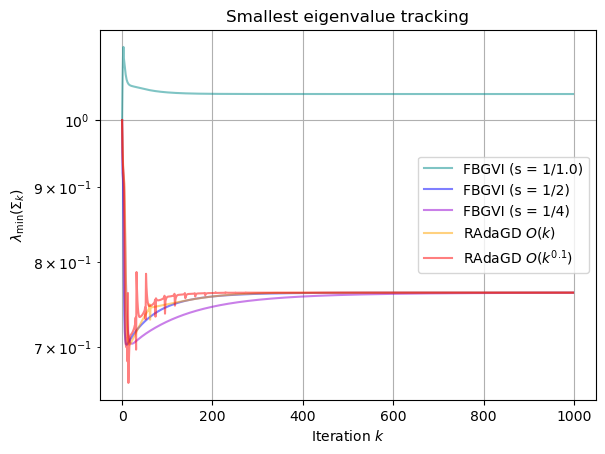

In [159]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"] # Labels for the legend

plt.plot(iterations, eigenvalue_fb_small_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.5)
plt.plot(iterations, eigenvalue_fb, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.5)
plt.plot(iterations, eigenvalue_fb_large_L, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.5)
#plt.plot(iterations, eigenvalue_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, eigenvalue_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
plt.plot(iterations, eigenvalue_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.5)
plt.plot(iterations, eigenvalue_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.5)
# plt.plot(iterations, eigenvalue_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.5)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"$\lambda_{{\min}}(\Sigma_k)$")
plt.title("Smallest eigenvalue tracking" )
plt.yscale('log', base = 10)
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

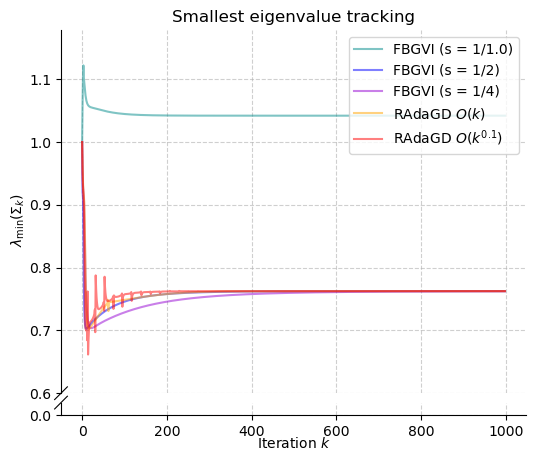

In [ ]:
iterations = list(range(num_subiter-1))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"]

# y axis range
min_val = min(np.min(eigenvalue_fb_small_L), np.min(eigenvalue_fb), 
              np.min(eigenvalue_fb_large_L), np.min(eigenvalue_a1), np.min(eigenvalue_a01))
max_val = max(np.max(eigenvalue_fb_small_L), np.max(eigenvalue_fb), 
              np.max(eigenvalue_fb_large_L), np.max(eigenvalue_a1), np.max(eigenvalue_a01))

fig = plt.figure(figsize=(6,5))

# brokenaxes: (0~0.02), (0.9~max_val)
bax = brokenaxes(ylims=((0, 0.02), (0.6, 1.05*max_val)), hspace=.05, fig=fig)

# plot
bax.plot(iterations, eigenvalue_fb_small_L, color=colors[7], label=labels[7], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_fb, color=colors[0], label=labels[0], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_fb_large_L, color=colors[8], label=labels[8], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_a1, color=colors[3], label=labels[3], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_a01, color=colors[4], label=labels[4], linestyle='-', alpha=0.5)

# label
bax.set_xlabel(r"Iteration $k$")
bax.set_title("Smallest eigenvalue tracking")

# ylabel not to collapse
fig.text(0.04, 0.5, r"$\lambda_{\min}(\Sigma_k)$",
         va="center", rotation="vertical")

# legend, grid
bax.legend()
bax.grid(True, linestyle="--", alpha=0.6)

plt.show()


Stepsize

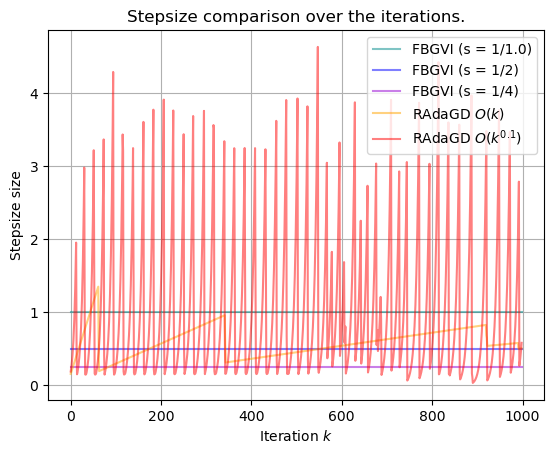

In [161]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"] # Labels for the legend

plt.plot(iterations, stepsize_fb_small_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.5)
plt.plot(iterations, stepsize_fb, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.5)
plt.plot(iterations, stepsize_fb_large_L, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.5)
#plt.plot(iterations, stepsize_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, stepsize_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.5)
plt.plot(iterations, stepsize_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.5)
# plt.plot(iterations, stepsize_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.5)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

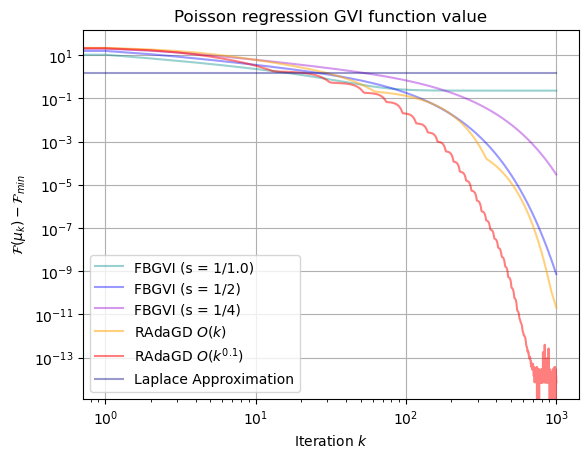

In [162]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"] # Labels for the legend

min_value_fb_small_L = np.min(fb_kl_list_small_L)
min_value_fb_large_L = np.min(fb_kl_list_large_L)
min_value_fb = np.min(fb_kl_list)
min_value_a01 = np.min(adap_gd_kl_list_a01)
# min_value_mal = np.min(adap_gd_kl_list_mal)
min_value = min(min_value_fb, min_value_a01, min_value_fb_small_L, min_value_fb_large_L)

plt.plot(iterations, fb_kl_list_small_L - min_value, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.4)
plt.plot(iterations, fb_kl_list - min_value, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, fb_kl_list_large_L - min_value, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_a1 - min_value, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.5)
plt.plot(iterations, adap_gd_kl_list_a01 - min_value, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.5)
# plt.plot(iterations, adap_gd_kl_list_mal - min_value, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)
plt.plot(iterations, laplace_kl_list - min_value, color=colors[6], label=labels[6],linestyle = '-', alpha = 0.4)

# plt.plot(iterations, fb_kl_list_small_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, fb_kl_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, fb_kl_list_large_L, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_kl_list_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
# # plt.plot(iterations, adap_gd_kl_list_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, laplace_kl_list, color=colors[6], label=labels[6],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"$\mathcal{F}(\mu_k) - \mathcal{F}_{{min}}$")
plt.title("Poisson regression GVI function value" )
plt.xscale('log',base=10)
plt.yscale('log', base = 10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Experiments in appendix

## Gamma regression with log-link

### Gamma regression with log-link components

In [ ]:
def log_potential_gamma_loglink(theta, Y, X, inv_dispersion=1.0, clip=None):
    """
    Gamma regression (log-link) negative log-potential:
        V(θ) = a * sum_i [ y_i * exp(-x_i^T θ) + x_i^T θ ], where k = inv_dispersion (=1/φ)

    If theta is (d,), returns a scalar.
    If theta is batched ((m,d) or (d,m)), returns (m,) values.

    Args:
        theta: (d,), (m,d), or (d,m)
        Y:     (n,)
        X:     (n,d)
        inv_dispersion: a > 0 (shape = 1/dispersion)
        clip:  optional float to clip the linear predictors before exp to stabilize
    """
    n, d = X.shape
    TH, was_single = _theta_as_batch(theta, d)    # (m, d)
    Z = X @ TH.T                                  # (n, m) = Xθ

    if clip is not None:
        # exp(-Z) is used; clipping Z keeps exp stable for extreme values
        Z = np.clip(Z, -clip, clip)

    y = np.asarray(Y).reshape(n, 1)               # (n,1)
    vals = (y * np.exp(-Z)).sum(axis=0) + Z.sum(axis=0)   # (m,)
    vals = float(inv_dispersion) * vals

    return vals[0] if was_single else vals


def grad_V_gamma_loglink(theta, Y, X, inv_dispersion=1.0):
    """
    Gamma (log-link) negative log-likelihood:
        V(θ) = a * sum_i [ y_i * exp(-x_i^T θ) + x_i^T θ ],  k = inv_dispersion

    Gradient:
        ∇V(θ) = a * X^T ( 1 - y ⊙ exp(-Xθ) )

    If theta is (d,), returns (d,).
    If batched, returns (m, d).
    """
    n, d = X.shape
    TH, was_single = _theta_as_batch(theta, d)     # (m, d)
    Z = X @ TH.T                                   # (n, m)
    E = np.exp(-Z)                                 # (n, m) = exp(-Xθ)
    y = np.asarray(Y).reshape(n, 1)                # (n, 1)

    G = (1.0 - y * E).T @ X                        # (m, d)
    G *= float(inv_dispersion)
    return G[0] if was_single else G


def hess_V_gamma_loglink(theta, Y, X, inv_dispersion=1.0):
    """
    Hessian:
        ∇²V(θ) = X^T diag( a * y ⊙ exp(-Xθ) ) X

    If theta is (d,), returns (d, d).
    If batched, returns (m, d, d).
    """
    n, d = X.shape
    TH, was_single = _theta_as_batch(theta, d)     # (m, d)
    Z = X @ TH.T                                   # (n, m)
    W = (np.asarray(Y).reshape(n, 1) * np.exp(-Z)) # (n, m): y ⊙ exp(-Xθ)
    W *= float(inv_dispersion)                     # scale by a

    # H[m, :, :] = sum_i W[i, m] * x_i x_i^T
    H = np.einsum('ni,nj,nm->mij', X, X, W)        # (m, d, d)
    return H[0] if was_single else H

def make_gamma_loglink_gaussian_moments(X, Y, inv_dispersion=1.0):
    """
    Gamma regression with log-link:
      V(θ) = a * Σ_i [ y_i * exp(-x_i^T θ) + x_i^T θ ],  where a = inv_dispersion = 1/b.

    Returns a function moments(mu, Sigma, clip=None) -> (EV, Egrad, EHess)
    giving E[V], E[∇V], E[∇²V] under θ ~ N(mu, Sigma).
    """
    X = np.asarray(X)
    y = np.asarray(Y)
    k = float(inv_dispersion)

    def moments(mu, Sigma, clip=None):
        XS = X @ Sigma                              # (n,d)
        s2 = np.einsum('nd,nd->n', XS, X)           # diag(X Σ X^T) ∈ R^n
        eta_mean = X @ mu                           # (n,)
        t = -eta_mean + 0.5 * s2                    # exponent for E[e^{-η}]
        if clip is not None:
            t = np.clip(t, -clip, clip)
        exp_neg_eta_bar = np.exp(t)                 # (n,)

        # E[V]
        EV = k * (y @ exp_neg_eta_bar + eta_mean.sum())

        # E[∇V] = a * X^T (1 - y ⊙ E[e^{-η}])
        Egrad = k * (X.T @ (1.0 - y * exp_neg_eta_bar))

        # E[∇²V] = X^T diag(a * y ⊙ E[e^{-η}]) X
        w = k * y * exp_neg_eta_bar                 # (n,)
        EHess = X.T @ (w[:, None] * X)              # (d,d)

        return EV, Egrad, EHess

    return moments

### Data generation

In [ ]:
np.random.seed(100)

num_sample, dim = 50, 25
X = mvn(np.zeros(dim), np.eye(dim), size=(num_sample))    # (n, d)

# optional global scaling (keeps conditioning manageable)
maxeig = np.linalg.eigvalsh(X.T @ X).max()
X = X / np.sqrt(maxeig + 1e-12)

# ---- true parameter and Gamma outcomes (log link) --------------------------
true_theta = mvn(np.zeros(dim), np.eye(dim))               # (d,)

# linear predictor and mean with log-link
eta_true = X @ true_theta                                  # (n,)
# guard against extreme exp over/underflow if you activate the outliers
# eta_true = np.clip(eta_true, -8.0, 8.0)

mu_true = np.exp(eta_true)                                 # E[Y_i] = mu_i

# inverse-dispersion (shape) a = 1/phi; Var[Y_i] = mu_i^2 / a
inv_dispersion_true = 5.0                                  # e.g., a=5 -> phi=0.2

# sample Y_i ~ Gamma(shape=a, scale=mu_i/a)
Y = np.random.gamma(shape=inv_dispersion_true,
                    scale=mu_true / inv_dispersion_true,
                    size=num_sample)                       # (n,), positive & continuous

# (Optional) tiny floor to avoid exact zeros in downstream code
Y = np.maximum(Y, 1e-12)

# ---- hook up the Gaussian-moment oracle for Gamma log-link -----------------
# assuming you defined this earlier (from my previous message)
# def make_gamma_loglink_gaussian_moments(X, Y, inv_dispersion=1.0): ...

gamma_gaussian_moment_ftn = make_gamma_loglink_gaussian_moments(
    X, Y, inv_dispersion=inv_dispersion_true
)


### Experiments

In [212]:
# Guess L
L = 6
small_L = L/2
large_L = 2 * L

# Experiment setup
num_subiter = 1000
A_order_experi = 0.1

# run experiment
fb_kl_list, fb_FI_list, fb_mu_last_j, fb_Sigma_last_j, stepsize_fb, eigenvalue_fb  = wasser_gds_glm(
    dim, gamma_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = False, prox = True
    )
print("FB Done")
adap_gd_kl_list_a1, adap_gd_FI_list_a1, adap_gd_mu_last_j_a1, adap_gd_Sigma_last_j_a1, stepsize_a1, eigenvalue_a1 = wasser_gds_glm(
    dim, gamma_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = 1
  )
print("AdaGDO(n) Done")
adap_gd_kl_list_a01, adap_gd_FI_list_a01, adap_gd_mu_last_j_a01, adap_gd_Sigma_last_j_a01, stepsize_a01, eigenvalue_a01 = wasser_gds_glm(
    dim, gamma_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = A_order_experi
  )
print(f"AdaGDO({A_order_experi})) Done")
fb_kl_list_large_L, fb_FI_list_large_L, fb_mu_last_j_large_L, fb_Sigma_last_j_large_L, stepsize_fb_large_L, eigenvalue_fb_large_L  = wasser_gds_glm(
    dim, gamma_gaussian_moment_ftn, num_subiter, step_size=1/large_L, adaptive = False, prox = True
    )
print("large_L FB Done")
fb_kl_list_small_L, fb_FI_list_small_L, fb_mu_last_j_small_L, fb_Sigma_last_j_small_L, stepsize_fb_small_L, eigenvalue_fb_small_L  = wasser_gds_glm(
    dim, gamma_gaussian_moment_ftn, num_subiter, step_size=1/small_L, adaptive = False, prox = True
    )
print("small_L FB Done")

FB Done


/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_2726/1861930576.py:107: RuntimeWarning: invalid value encountered in log
  L_e = np.exp(np.log(numerator) - np.log(denominator))


AdaGDO(n) Done
AdaGDO(0.1)) Done
large_L FB Done
small_L FB Done


Laplace approximation

In [213]:
# Laplace approximation
log_potential_pure = partial(log_potential_gamma_loglink, Y=Y, X=X)
grad_pure = partial(grad_V_gamma_loglink, Y=Y, X=X)
hess_pure = partial(hess_V_gamma_loglink, Y=Y, X=X)
laplace_kl_list = []
la_mu, la_Sigma = laplace_approx(dim, log_potential_pure, grad_pure, hess_pure)
EV, _, _ = gamma_gaussian_moment_ftn(la_mu, la_Sigma)
la_kl = EV + H(la_mu, la_Sigma)
# la_FI = empirical_FI(la_mu, la_Sigma, grad_pure, size = 10000)
for i in range(num_subiter):
  laplace_kl_list.append(la_kl)

/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_2726/2407819757.py:58: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(log_potential, x0, jac = grad_V, hess = hess_V)


### Plotting

Eigenvalue

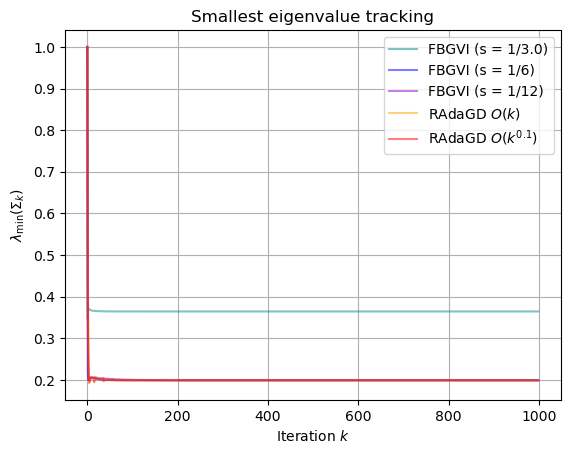

In [214]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"] # Labels for the legend

plt.plot(iterations, eigenvalue_fb_small_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.5)
plt.plot(iterations, eigenvalue_fb, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.5)
plt.plot(iterations, eigenvalue_fb_large_L, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.5)
#plt.plot(iterations, eigenvalue_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, eigenvalue_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
plt.plot(iterations, eigenvalue_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.5)
plt.plot(iterations, eigenvalue_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.5)
# plt.plot(iterations, eigenvalue_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.5)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"$\lambda_{{\min}}(\Sigma_k)$")
plt.title("Smallest eigenvalue tracking" )
# plt.yscale('log', base = 10)
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

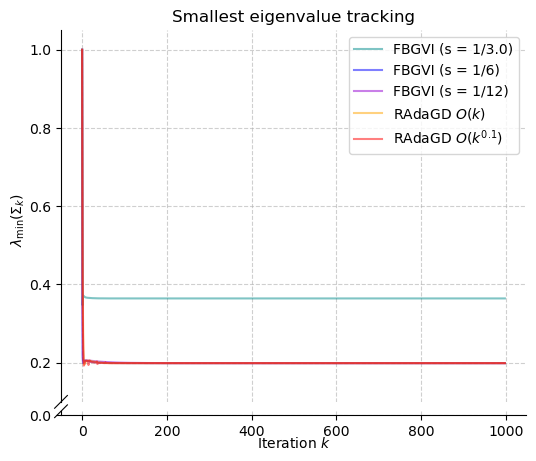

In [217]:
iterations = list(range(num_subiter-1))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"]

# y axis range
min_val = min(np.min(eigenvalue_fb_small_L), np.min(eigenvalue_fb), 
              np.min(eigenvalue_fb_large_L), np.min(eigenvalue_a1), np.min(eigenvalue_a01))
max_val = max(np.max(eigenvalue_fb_small_L), np.max(eigenvalue_fb), 
              np.max(eigenvalue_fb_large_L), np.max(eigenvalue_a1), np.max(eigenvalue_a01))

fig = plt.figure(figsize=(6,5))

# brokenaxes: (0~0.02), (0.9~max_val)
bax = brokenaxes(ylims=((0, 0.01), (0.1, 1.05*max_val)), hspace=.05, fig=fig)

# plot
bax.plot(iterations, eigenvalue_fb_small_L, color=colors[7], label=labels[7], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_fb, color=colors[0], label=labels[0], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_fb_large_L, color=colors[8], label=labels[8], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_a1, color=colors[3], label=labels[3], linestyle='-', alpha=0.5)
bax.plot(iterations, eigenvalue_a01, color=colors[4], label=labels[4], linestyle='-', alpha=0.5)

# label
bax.set_xlabel(r"Iteration $k$")
bax.set_title("Smallest eigenvalue tracking")

# ylabel not to collapse
fig.text(0.04, 0.5, r"$\lambda_{\min}(\Sigma_k)$",
         va="center", rotation="vertical")

# legend, grid
bax.legend()
bax.grid(True, linestyle="--", alpha=0.6)

plt.show()

Stepsize

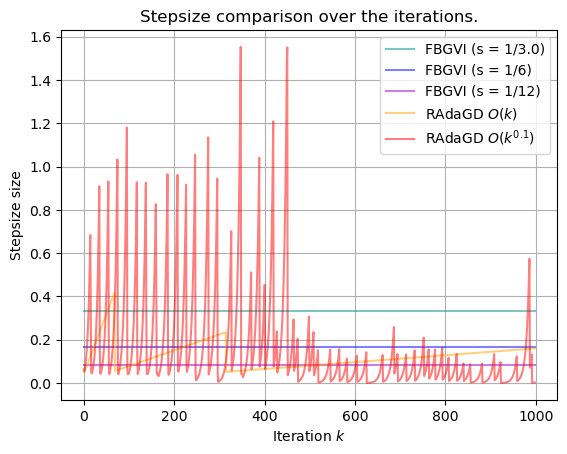

In [218]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"] # Labels for the legend

plt.plot(iterations, stepsize_fb_small_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.5)
plt.plot(iterations, stepsize_fb, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.5)
plt.plot(iterations, stepsize_fb_large_L, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.5)
#plt.plot(iterations, stepsize_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, stepsize_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.5)
plt.plot(iterations, stepsize_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.5)
# plt.plot(iterations, stepsize_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.5)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

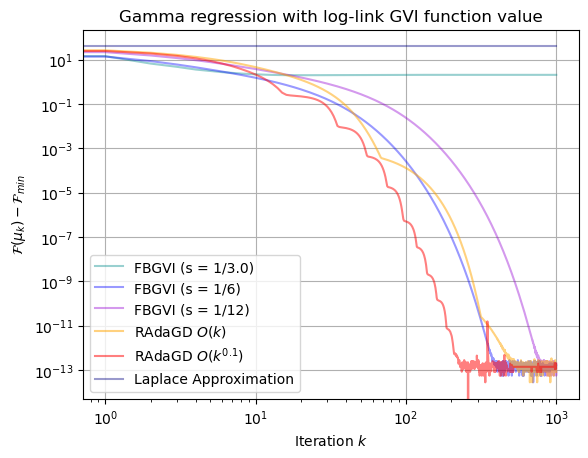

In [219]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"FBGVI (s = 1/{L})", "RAdaGD (O(1))",
          "RAdaGD (O(k^{0.5}))", r"RAdaGD $O(k)$",
          fr"RAdaGD $O(k^{{{A_order_experi}}})$","[AM25]", "Laplace Approximation",
          f"FBGVI (s = 1/{small_L})", f"FBGVI (s = 1/{large_L})"] # Labels for the legend

min_value_fb_small_L = np.min(fb_kl_list_small_L)
min_value_fb_large_L = np.min(fb_kl_list_large_L)
min_value_fb = np.min(fb_kl_list)
min_value_a01 = np.min(adap_gd_kl_list_a01)
# min_value_mal = np.min(adap_gd_kl_list_mal)
min_value = min(min_value_fb, min_value_a01, min_value_fb_small_L, min_value_fb_large_L)

plt.plot(iterations, fb_kl_list_small_L - min_value, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.4)
plt.plot(iterations, fb_kl_list - min_value, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, fb_kl_list_large_L - min_value, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_a1 - min_value, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.5)
plt.plot(iterations, adap_gd_kl_list_a01 - min_value, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.5)
# plt.plot(iterations, adap_gd_kl_list_mal - min_value, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)
plt.plot(iterations, laplace_kl_list - min_value, color=colors[6], label=labels[6],linestyle = '-', alpha = 0.4)

# plt.plot(iterations, fb_kl_list_small_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, fb_kl_list, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, fb_kl_list_large_L, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_kl_list_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
# # plt.plot(iterations, adap_gd_kl_list_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, laplace_kl_list, color=colors[6], label=labels[6],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel(r"Iteration $k$")
plt.ylabel(r"$\mathcal{F}(\mu_k) - \mathcal{F}_{{min}}$")
plt.title("Gamma regression with log-link GVI function value" )
plt.xscale('log',base=10)
plt.yscale('log', base = 10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Poisson regression under worst-case (Anisotropic + heavy-tail)

In [182]:
np.random.seed(1234)

# --- design X: anisotropic + outliers --------------------------------------
num_sample, dim = 100, 50

# --- make X anisotropic and add leverage outliers -------------------------
X = mvn(np.zeros(dim), np.eye(dim), size=(num_sample))    # (n, d)

# # (A) Column anisotropy: scale columns by a geometric range (raises κ(X^TX))
# scales = np.geomspace(1.0, 100.0, dim)                    # cond ~ 100
# X = X * scales                                            # broadcast over columns

# # (B) A few extreme rows along ±v (create huge exp(x_i^T θ) contrasts)
# k = max(1, int(0.1 * num_sample))                        # ~10% rows
# v = np.random.randn(dim)
# v /= (np.linalg.norm(v) + 1e-12)
# X[:k]      = 200 * v                                     # very large positive dot
# X[k:2*k]   = 200 * v                                    # very large negative dot

# optional global scaling (keeps conditioning manageable)
maxeig = np.linalg.eigvalsh(X.T @ X).max()
X = X / np.sqrt(maxeig)

# --- true parameter and Poisson outcomes -----------------------------------
true_theta = mvn(np.zeros(dim), np.eye(dim))                 # (d,)
z_true = X @ true_theta
# z_true = np.clip(z_true, -8.0, 8.0)                          # keep rates sane
lam_true = np.exp(z_true)                                    # (n,)
Y = np.random.poisson(lam_true)                              # (n,)

# Model
poisson_gaussian_moment_ftn = make_poisson_gaussian_moments(X, Y)

Simulations

In [42]:
# Guess L
L = 2
small_L = L/2
large_L = 2 * L
A_order_experi = 0.1

num_subiter = 1000
minibatch = 1
# run experiment
# gd_kl_list_final, gd_FI_list_final, gd_mu_last_j, gd_Sigma_last_j, stepsize_gd  = wasser_gds_poisson(
#     dim, grad_pure, hess_pure, log_potential_pure, num_subiter, step_size=1/L, adaptive = False, num_minibatch = minibatch
#     )
# print("GD Done")
# run experiment
fb_kl_list, fb_FI_list, fb_mu_last_j, fb_Sigma_last_j, stepsize_fb  = wasser_gds_poisson(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = False, prox = True
    )
print("FB Done")
adap_gd_kl_list_a01, adap_gd_FI_list_a01, adap_gd_mu_last_j_a01, adap_gd_Sigma_last_j_a01, stepsize_a01 = wasser_gds_poisson(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1e-3/L, adaptive = True, A_order = A_order_experi
  )
print(f"AdaGDO({A_order_experi})) Done")
adap_gd_kl_list_mal, adap_gd_FI_list_mal, adap_gd_mu_last_j_mal, adap_gd_Sigma_last_j_mal, stepsize_mal = wasser_gds_poisson(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1e-3/L, adaptive = True, ours = False, A_order = 1
  )
print("MalGD Done")
fb_kl_list_small_L, fb_FI_list_small_L, fb_mu_last_j_small_L, fb_Sigma_last_j_small_L, stepsize_fb_small_L  = wasser_gds_poisson(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/small_L, adaptive = False, prox = True
    )
print("small_L FB Done")
fb_kl_list_large_L, fb_FI_list_large_L, fb_mu_last_j_large_L, fb_Sigma_last_j_large_L, stepsize_fb_large_L  = wasser_gds_poisson(
    dim, poisson_gaussian_moment_ftn, num_subiter, step_size=1/large_L, adaptive = False, prox = True
    )
print("large_L FB Done")

ValueError: too many values to unpack (expected 5)

Laplace approximation

In [37]:
# Laplace approximation
log_potential_pure = partial(log_potential_poisson, Y=Y, X=X)
grad_pure = partial(grad_V_poisson, Y=Y, X=X)
hess_pure = partial(hess_V_poisson, Y=Y, X=X)
laplace_kl_list = []
laplace_FI_list = []
la_mu, la_Sigma = laplace_approx(dim, log_potential_pure, grad_pure, hess_pure)
EV, _, _ = poisson_gaussian_moment_ftn(la_mu, la_Sigma)
la_kl = EV + H(la_mu, la_Sigma)
for i in range(num_subiter):
  laplace_kl_list.append(la_kl)

/var/folders/zj/m2bc_5qd3gq_tddbny9n_wqr0000gn/T/ipykernel_44796/2407819757.py:58: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(log_potential, x0, jac = grad_V, hess = hess_V)


### Plotting

Stepsize

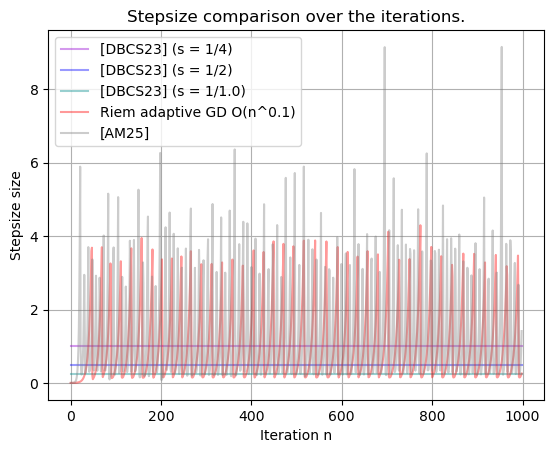

In [38]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"[DBCS23] (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", "Riem adaptive GD (O(n))",
          f"Riem adaptive GD O(n^{A_order_experi})","[AM25]", "Laplace Approximation",
          f"[DBCS23] (s = 1/{small_L})", f"[DBCS23] (s = 1/{large_L})"] # Labels for the legend

plt.plot(iterations, stepsize_fb_small_L, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_fb, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_fb_large_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.4)
#plt.plot(iterations, stepsize_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, stepsize_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, stepsize_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

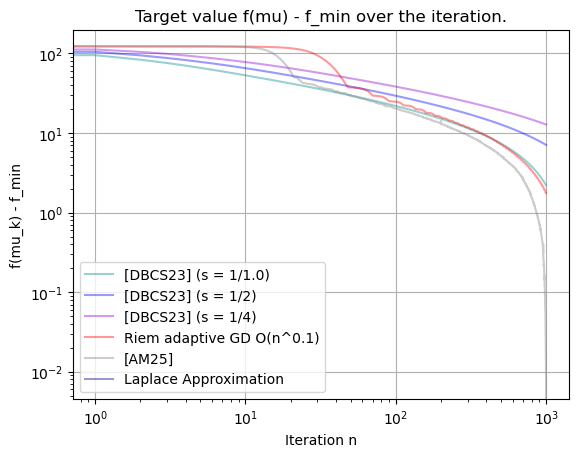

In [41]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy", "darkcyan", "darkviolet"]
labels = [f"[DBCS23] (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", "Riem adaptive GD (O(n))",
          f"Riem adaptive GD O(n^{A_order_experi})","[AM25]", "Laplace Approximation",
          f"[DBCS23] (s = 1/{small_L})", f"[DBCS23] (s = 1/{large_L})"] # Labels for the legend

min_value_fb_small_L = np.min(fb_kl_list_small_L)
min_value_fb_large_L = np.min(fb_kl_list_large_L)
min_value_fb = np.min(fb_kl_list)
min_value_a01 = np.min(adap_gd_kl_list_a01)
min_value_mal = np.min(adap_gd_kl_list_mal)
min_value = min(min_value_fb, min_value_a01, min_value_mal, min_value_fb_small_L, min_value_fb_large_L)

plt.plot(iterations, fb_kl_list_small_L - min_value, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.4)
plt.plot(iterations, fb_kl_list - min_value, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
plt.plot(iterations, fb_kl_list_large_L - min_value, color=colors[8], label=labels[8], linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_kl_list_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_kl_list_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, adap_gd_kl_list_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_a01 - min_value, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_mal - min_value, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)
plt.plot(iterations, laplace_kl_list - min_value, color=colors[6], label=labels[6],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, fb_kl_list_small_L, color=colors[7], label=labels[7], linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("f(mu_k) - f_min")
plt.title("Target value f(mu) - f_min over the iteration." )
plt.xscale('log',base=10)
plt.yscale('log', base = 10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

### Additional task: quantile regression

Quantile regression target

In [42]:
from scipy.special import erf

def make_quantile_gaussian_moments(X, Y, tau):
    """
    Moments for quantile (pinball) loss under θ ~ N(m, Σ).

    Loss per sample: ρ_τ(u) = τ·u_+ + (1-τ)·(-u)_+, with u = y - x^T θ
    Potential: V(θ) = sum_i ρ_τ(y_i - x_i^T θ)

    Returns a callable moments(mu, Sigma, clip=None, eps=1e-12) that computes:
      EV    = E[V(θ)]
      Egrad = E[∇_θ V(θ)]      = sum_i (Φ(α_i) - τ) x_i
      EHess = E[∇^2_θ V(θ)]    = sum_i (φ(α_i)/s_i) x_i x_i^T
    where:
      μ_i   = x_i^T m
      s_i   = sqrt(x_i^T Σ x_i)
      α_i   = (μ_i - y_i)/s_i
      Φ, φ  = std normal CDF/PDF

    Notes:
      - Matches your Poisson function's API and "sum" (not 1/n) convention.
      - Requires Σ ≻ 0; we guard s_i by eps to avoid division issues.
      - Optional 'clip' bounds α for extra numerical safety.
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(Y, dtype=float)
    tau = float(tau)
    if not (0.0 < tau < 1.0):
        raise ValueError("tau must be in (0,1).")

    sqrt2 = np.sqrt(2.0)
    inv_sqrt_2pi = 1.0 / np.sqrt(2.0 * np.pi)

    def std_norm_cdf(z):
        # Φ(z) = 0.5 * (1 + erf(z / sqrt(2)))
        return 0.5 * (1.0 + erf(z / sqrt2))

    def std_norm_pdf(z):
        # φ(z) = (2π)^(-1/2) * exp(-z^2 / 2)
        return inv_sqrt_2pi * np.exp(-0.5 * z * z)

    def moments(mu, Sigma, clip=None, eps=1e-12):
        mu = np.asarray(mu, dtype=float)
        Sigma = np.asarray(Sigma, dtype=float)

        # s_i = sqrt(diag(X Σ X^T)) computed vectorially
        XS = X @ Sigma                        # (n,d)
        s2 = np.einsum('nd,nd->n', XS, X)     # (n,)
        s = np.sqrt(np.maximum(s2, eps))      # (n,), guard positivity

        mu_i = X @ mu                         # (n,)
        alpha = (mu_i - y) / s                # (n,)

        if clip is not None:
            # Optional: cap |alpha| for numerical stability in extreme tails
            alpha = np.clip(alpha, -clip, clip)

        Phi = std_norm_cdf(alpha)             # (n,)
        phi = std_norm_pdf(alpha)             # (n,)

        # EV = sum_i [ s_i φ(α_i) + (μ_i - y_i) (Φ(α_i) - τ) ]
        EV = np.sum(s * phi + (mu_i - y) * (Phi - tau))

        # Egrad = X^T (Φ(α) - τ)
        Egrad = X.T @ (Phi - tau)

        # EHess = X^T diag( φ(α)/s ) X
        w = (phi / s)[:, None]                # (n,1)
        EHess = X.T @ (w * X)                 # (d,d)

        return EV, Egrad, EHess

    return moments

Wasserstein quantile regression module

In [225]:
def wasser_gds_quantile(dim, quantile_gaussian_moment_ftn, num_iter,
                       step_size = 1, adaptive = True, ours = True, A_order = 0,
                       prox = False, num_minibatch = 100, init_mu = None, init_Sigma = None):
  """
  Conduct GD for KL(\mu || \pi) = V(\mu) + H(\mu)
  """
  # create a list to save the result
  gd_kl_list = []
  gd_FI_list = []
  # create a step-size list
  stepsize_list = []

  # initialize
  if init_mu is None:
    gd_mu_k = np.zeros(dim)
  else:
    gd_mu_k = init_mu
  if init_Sigma is None:
    gd_Sigma_k = np.eye(dim)
  else:
    gd_Sigma_k = init_Sigma

  # save the initial result: log error
  EV, _, _ = quantile_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
  current_gd_kl = EV + H(gd_mu_k, gd_Sigma_k)
  gd_kl_list.append(current_gd_kl)
  # FI
  # current_gd_log_FI = empirical_FI(gd_mu_k, gd_Sigma_k, grad_pure, size = num_minibatch)
  # gd_FI_list.append(current_gd_log_FI)

  # For adaptive methods
  list_len = num_iter + 2
  A = [None] * (list_len)
  B = [None] * (list_len)
  for i in range(list_len):
    if A_order == 1:
      A[i] = (i+5)/2
      B[i] = (i+1)/2
    elif A_order == 0.5:
      a = 2
      A[i] = 2 * np.sqrt(i+a) + 2
      B[i] = 2 * np.sqrt(i+a-2) - 2 + (5 / (1 + 2 * np.sqrt(i+a-2)))
    elif A_order == 0:
      A[i] = 3
      B[i] = 5/4
    else:
      a = 2
      A[i] = 2 * np.power(i+a, A_order) + 2
      B[i] = 2 * np.power(i+a-2, A_order) - 2 + (5 / (1 + 2 * np.power(i+a-2, A_order)))
  s0 = step_size
  s_t1 = s0
  L_e = L
  theta_t = 0
  s_prev = s_t1

  # run the gradient methods
  for curr_iter in range(2, num_iter + 1):
    # calculate gradient
    EV, gd_nabla_1, gd_nabla_2 = quantile_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
    # compute adaptive stepsize
    if adaptive:
      if ours:
        t= curr_iter
        s_prev = s_t1
        if t == 0:
          s_t1 = min( 1/A[0] * s_prev, A[0] * B[0] / ( A[0]**2 + B[0] * (B[1] + 1) ) * 1/L_e)
        elif t >= 1:
          t = t+1
          r_s = (A[t-2]+1)/A[t-1]
          if L_e > 0:
            if s_prev >= (1/L_e):
              r_l = A[t-1] * B[t-1] / ( A[t-1]**2 + B[t-1] * (B[t] + 1) )
            else:
              r_l = A[t-1]/(B[t] + 1)
            s_t1 = min( r_s * s_prev, r_l * 1/L_e)
          else:
            s_t1 = r_s * s_prev

        # adaptive GD update
        stepsize_list.append(s_t1)
        f_old = EV + H(gd_mu_k, gd_Sigma_k)
        gd_mu_next, gd_Sigma_next = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, s_t1, dim, prox = False)
        # gd_Sigma_next = enforce_spd(gd_Sigma_next)
        EV_next, gd_nabla_1_next, gd_nabla_2_next = quantile_gaussian_moment_ftn(gd_mu_next, gd_Sigma_next)
        f_new = EV_next + H(gd_mu_next, gd_Sigma_next)

        # compute adaptive stepsize
        grad_vec_new = gd_nabla_1_next
        grad_mat_new = gd_nabla_2_next - np.linalg.inv(gd_Sigma_next)
        g_new = gaussian_transport(
            gd_Sigma_k, gd_Sigma_next, grad_vec_new, grad_mat_new
        )
        grad_vec_old = gd_nabla_1
        grad_mat_old = gd_nabla_2 - np.linalg.inv(gd_Sigma_k)
        g_old = (grad_vec_old, grad_mat_old)
        numerator = bw_inner_product(g_old[0] - g_new[0], g_old[1] - g_new[1], g_old[0] - g_new[0], g_old[1] - g_new[1], gd_Sigma_k)
        if numerator == 0:
          L_e = 0
        else:
          denominator = -2*(f_new - f_old + s_t1 * bw_inner_product(g_old[0], g_old[1], g_new[0], g_new[1], gd_Sigma_k))
          # log-stabilization
          L_e = np.exp(np.log(numerator) - np.log(denominator))
          if L_e < 0 or (math.isnan(L_e)):
              L_e = 0
      # Malitsky
      else:
        stepsize_list.append(s_t1)
        # gradient step
        gd_mu_next, gd_Sigma_next = one_step_grad(
            gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, s_t1, dim, prox=False
        )
        # gd_Sigma_next = enforce_spd(gd_Sigma_next)

        _, gd_nabla_1_next, gd_nabla_2_next = quantile_gaussian_moment_ftn(
            gd_mu_next, gd_Sigma_next
        )
        grad_vec_next = gd_nabla_1_next
        grad_mat_next = gd_nabla_2_next - np.linalg.inv(gd_Sigma_next)

        # old gradient at x_k (split like you already do)
        grad_vec_old = gd_nabla_1
        grad_mat_old = gd_nabla_2 - np.linalg.inv(gd_Sigma_k)

        # transport old → new, and measure differences at the NEW base point
        g_old_on_new = gaussian_transport(
            gd_Sigma_next, gd_Sigma_k, grad_vec_old, grad_mat_old
        )
        prev_vec_on_new, prev_mat_on_new = g_old_on_new

        # Riemannian norms (not squared) with correct base points
        norm_prev = math.sqrt(
            bw_inner_product(grad_vec_old, grad_mat_old,
                            grad_vec_old, grad_mat_old, gd_Sigma_k)
        )
        diff_vec = grad_vec_next - prev_vec_on_new
        diff_mat = grad_mat_next - prev_mat_on_new
        norm_diff = math.sqrt(
            bw_inner_product(diff_vec, diff_mat, diff_vec, diff_mat, gd_Sigma_next)
        )

        if (norm_diff == 0.0) or math.isnan(norm_diff):
            s_next = math.sqrt(1.0 + theta_t) * s_prev

        else:
            L_e_inv = (s_prev * norm_prev) / (math.sqrt(2.0) * norm_diff)
            s_next = min(math.sqrt(1.0 + theta_t) * s_prev, L_e_inv)

        theta_t = 0.0 if s_prev == 0.0 else (s_next / s_prev)

        s_prev = s_next
        s_t1   = s_next

      gd_mu_k, gd_Sigma_k = gd_mu_next, gd_Sigma_next
    # Conduct Forward-Backward BWVI
    else:
      if prox:
        # Forward-backward update
        gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, step_size, dim, prox = True)
      else:
        # Wasserstein GD
        gd_mu_k, gd_Sigma_k = one_step_grad(gd_mu_k, gd_Sigma_k, gd_nabla_1, gd_nabla_2, step_size, dim, prox = False)
      gd_Sigma_k = enforce_spd(gd_Sigma_k)
      stepsize_list.append(step_size)

    # save the initial result: log error
    EV, _, _ = quantile_gaussian_moment_ftn(gd_mu_k, gd_Sigma_k)
    current_gd_kl = EV + H(gd_mu_k, gd_Sigma_k)
    gd_kl_list.append(current_gd_kl)

  # save the last result
  gd_mu_last = gd_mu_k
  gd_Sigma_last = gd_Sigma_k

  # return the result
  return gd_kl_list, gd_FI_list, gd_mu_last, gd_Sigma_last, stepsize_list

### Simulations

Generate synthetic data

In [45]:
def sample_asymmetric_laplace(size, tau=0.5, scale=1.0):
    """
    Draws ε ~ ALD(τ, scale) with density ∝ exp(-ρ_τ(ε)/scale).
    P(ε ≤ 0) = τ, so 0 is the τ-quantile.
    """
    u = np.random.rand(size)
    pos = (u < 1.0 - tau)  # P(ε >= 0) = 1 - τ

    # Exponential parameterization: numpy uses 'scale' = 1/rate
    # For ε >= 0: Exp(rate = τ/scale)  -> scale_pos = scale / τ
    # For ε < 0 : -Exp(rate = (1-τ)/scale) -> scale_neg = scale / (1-τ)
    e_pos = np.random.exponential(scale / max(tau, 1e-12), size)
    e_neg = np.random.exponential(scale / max(1.0 - tau, 1e-12), size)
    eps = np.where(pos, e_pos, -e_neg)
    return eps

# ---------------- Example: generate X, true θ, and Y for quantile regression ----------------
np.random.seed(1234)

num_sample, dim = 50, 25
X = mvn(np.zeros(dim), np.eye(dim), size=(num_sample))  # (n, d)

# Optional global scaling (keeps conditioning manageable)
maxeig = np.linalg.eigvalsh(X.T @ X).max()
X = X / np.sqrt(maxeig)

# ----- choose quantile and noise scale -----
tau = 0.1         # median regression; use any tau in (0,1)
noise_scale = 2.0  # ALD scale parameter (larger => heavier tails)

# ----- true parameter and outcomes for quantile regression -----
true_theta = mvn(np.zeros(dim), np.eye(dim))      # (d,)
z_true = X @ true_theta                            # linear predictor
eps = sample_asymmetric_laplace(num_sample, tau=tau, scale=noise_scale)
Y = z_true + eps                                   # real-valued responses

# (Optional) build the Gaussian-moment oracle you created earlier:
quantile_gaussian_moment_ftn = make_quantile_gaussian_moments(X, Y, tau)


Experiments

In [46]:
# Guess L
L = 0.02
A_order_experi = 0.1

num_subiter = 1000
minibatch = 1
# run experiment
# gd_kl_list_final, gd_FI_list_final, gd_mu_last_j, gd_Sigma_last_j, stepsize_gd  = wasser_gds_poisson(
#     dim, grad_pure, hess_pure, log_potential_pure, num_subiter, step_size=1/L, adaptive = False, num_minibatch = minibatch
#     )
# print("GD Done")
# run experiment
fb_kl_list, fb_FI_list, fb_mu_last_j, fb_Sigma_last_j, stepsize_fb  = wasser_gds_quantile(
    dim, quantile_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = False, num_minibatch = minibatch, prox = True
    )
print("FB Done")
# adap_gd_kl_list_a0, adap_gd_FI_list_a0, adap_gd_mu_last_j_a0, adap_gd_Sigma_last_j_a0, stepsize_a0 = wasser_gds_quantile(
#     dim, quantile_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = 0, num_minibatch = minibatch
#   )
# print("AdaGDO(1) Done")
# adap_gd_kl_list_a05, adap_gd_FI_list_a05, adap_gd_mu_last_j_a05, adap_gd_Sigma_last_j_a05, stepsize_a05 = wasser_gds_quantile(
#     dim, quantile_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = 0.5, num_minibatch = minibatch
#   )
# print("AdaGDO(1/2) Done")
# adap_gd_kl_list_a1, adap_gd_FI_list_a1, adap_gd_mu_last_j_a1, adap_gd_Sigma_last_j_a1, stepsize_a1 = wasser_gds_quantile(
#     dim, quantile_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = 1, num_minibatch = minibatch
#   )
# print("AdaGDO(n) Done")
adap_gd_kl_list_a01, adap_gd_FI_list_a01, adap_gd_mu_last_j_a01, adap_gd_Sigma_last_j_a01, stepsize_a01 = wasser_gds_quantile(
    dim, quantile_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, A_order = A_order_experi, num_minibatch = minibatch
  )
print(f"AdaGDO({A_order_experi})) Done")
adap_gd_kl_list_mal, adap_gd_FI_list_mal, adap_gd_mu_last_j_mal, adap_gd_Sigma_last_j_mal, stepsize_mal = wasser_gds_quantile(
    dim, quantile_gaussian_moment_ftn, num_subiter, step_size=1/L, adaptive = True, ours = False, A_order = 1, num_minibatch = minibatch
  )
print("MalGD Done")

FB Done
AdaGDO(0.1)) Done
MalGD Done


Stepsizes

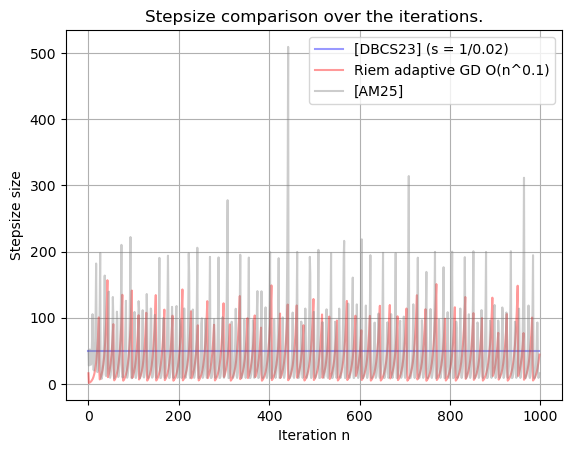

In [47]:
iterations = list(range((num_subiter-1)))  # Create the x-axis (iteration numbers)
colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy"]
labels = [f"[DBCS23] (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", "Riem adaptive GD (O(n))",
          f"Riem adaptive GD O(n^{A_order_experi})","[AM25]", "Laplace Approximation"] # Labels for the legend

plt.plot(iterations, stepsize_fb, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
#plt.plot(iterations, stepsize_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, stepsize_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, stepsize_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_a01, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, stepsize_mal, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("Stepsize size")
plt.title("Stepsize comparison over the iterations." )
# plt.xscale('log',base=10)
# plt.ylim(top = stepsize_a1[100])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Function value

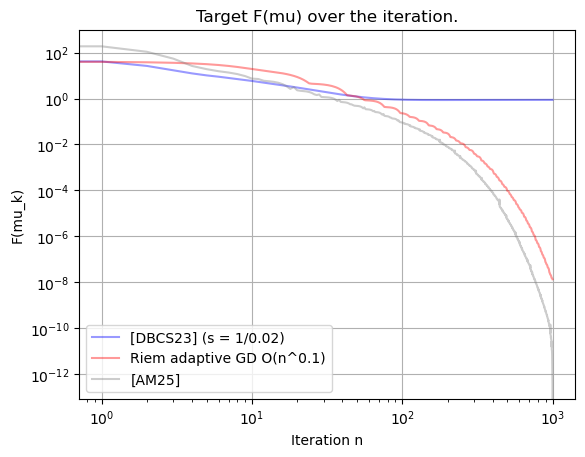

In [48]:
iterations = list(range((num_subiter)))  # Create the x-axis (iteration numbers)

colors = ['blue', 'green', "purple", "orange", "red", "grey", "navy"]
labels = [f"[DBCS23] (s = 1/{L})", "Riem adaptive GD (O(1))",
          "Riem adaptive GD (O(n^{0.5}))", "Riem adaptive GD (O(n))",
          f"Riem adaptive GD O(n^{A_order_experi})","[AM25]", "Laplace Approximation"] # Labels for the legend

min_value_01 = np.min(adap_gd_kl_list_a01)
min_value_fb = np.min(fb_kl_list)
min_value_mal = np.min(adap_gd_kl_list_mal)
min_value = min(min_value_01, min_value_fb, min_value_mal)

plt.plot(iterations, fb_kl_list - min_value, color=colors[0], label=labels[0], linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_kl_list_a0, color=colors[1], label=labels[1],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_kl_list_a05, color=colors[2], label=labels[2],linestyle = '-', alpha = 0.4)
#plt.plot(iterations, adap_gd_kl_list_a1, color=colors[3], label=labels[3],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_a01 - min_value, color=colors[4], label=labels[4],linestyle = '-', alpha = 0.4)
plt.plot(iterations, adap_gd_kl_list_mal - min_value, color=colors[5], label=labels[5],linestyle = '-', alpha = 0.4)
# plt.plot(iterations, laplace_kl_list, color=colors[6], label=labels[6],linestyle = '-', alpha = 0.4)

# Add labels and title
plt.xlabel("Iteration n")
plt.ylabel("F(mu_k)")
plt.title("Target F(mu) over the iteration." )
plt.xscale('log',base=10)

plt.yscale('log',base=10)
# plt.ylim(top = gd_v_list_final[0])

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()